In [1]:
import matplotlib.pyplot as plt
from cycler import cycler
import pandas as pd


In [14]:
# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

In [15]:
example_path = "C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 5 (POP)/model/Zgabay_Evo5.xlsx"
try:
    xls = pd.ExcelFile(example_path, engine="openpyxl")
    print("Sheets:", xls.sheet_names)
except FileNotFoundError:
    print(f"找不到文件: {example_path}")
except Exception as e:
    print("读取 Excel 时出错:", e)

Sheets: ['Information', 'Signal Summary', 'Grid', 'pressure_drop', 'pressure_drop (2)']


In [16]:
# 读取指定 sheet（'pressure_drop (2)'），打印标题和列名，并将每列数据导出为 notebook 变量（变量名由列名简化而来）
sheet_name = "pressure_drop (2)"

try:
    # 读取为带列名的 DataFrame
    sheet_df = xls.parse(sheet_name)
except Exception as e:
    raise RuntimeError(f"无法读取 sheet '{sheet_name}': {e}")

# 尝试从最上方单元格判断是否存在显式的标题（例如表格上方有单独的一行标题）
_rows = xls.parse(sheet_name, header=None)
top_cell = _rows.iloc[0, 0] if not _rows.empty else None
if isinstance(top_cell, str) and top_cell.strip() and top_cell.strip() not in list(sheet_df.columns):
    sheet_title = top_cell.strip()
else:
    sheet_title = sheet_name

print("Sheet title:", sheet_title)
print("Columns:", list(sheet_df.columns))

# 将每一列导出为变量，变量名由列名规范化得到（非字母数字替换为下划线，若以数字开头则加前缀下划线）
created_vars = {}
for col in sheet_df.columns:
    # 跳过完全空的列名
    if col is None:
        continue
    name = str(col).strip()
    if not name:
        continue
    # 规范化为合法的 Python 标识符
    var_name = ''.join(ch if (ch.isalnum() or ch == "_") else "_" for ch in name)
    if var_name and var_name[0].isdigit():
        var_name = "_" + var_name
    if not var_name:
        var_name = "col"
    base = var_name
    i = 1
    # 避免覆盖已有全局变量
    while var_name in globals():
        var_name = f"{base}_{i}"
        i += 1
    # 将该列作为 pandas Series 赋值到全局命名空间
    globals()[var_name] = sheet_df[col]
    created_vars[var_name] = col

print(f"Created {len(created_vars)} variables from sheet '{sheet_name}':")
for vn, col in created_vars.items():
    print(f"  {vn}  <- column '{col}' (length={len(globals()[vn])})")

# 显示前几行作为校验
print("\nPreview (first 5 rows) of the dataframe:")
print(sheet_df.head())

Sheet title: pressure_drop (2)
Columns: ['Date-Time', 13004, 13713, 14851, 15321, 16598, 17423, 'delta_time']
Created 8 variables from sheet 'pressure_drop (2)':
  Date_Time_1  <- column 'Date-Time' (length=52988)
  _13004_1  <- column '13004' (length=52988)
  _13713_1  <- column '13713' (length=52988)
  _14851_1  <- column '14851' (length=52988)
  _15321_1  <- column '15321' (length=52988)
  _16598_1  <- column '16598' (length=52988)
  _17423_1  <- column '17423' (length=52988)
  delta_time_1  <- column 'delta_time' (length=52988)

Preview (first 5 rows) of the dataframe:
            Date-Time     13004    13713     14851     15321     16598  \
0 2022-03-15 09:00:00  0.000000  0.00000  0.000000  0.000000  0.000000   
1 2022-03-15 09:00:10  0.787000 -0.00218  0.000000  0.000000 -0.007625   
2 2022-03-15 09:00:20  0.787000 -0.00218  0.012052  0.067000 -0.012000   
3 2022-03-15 09:00:30  1.058329  0.00482  0.019000  0.067000 -0.012000   
4 2022-03-15 09:00:40  1.216000  0.00482  0.006966

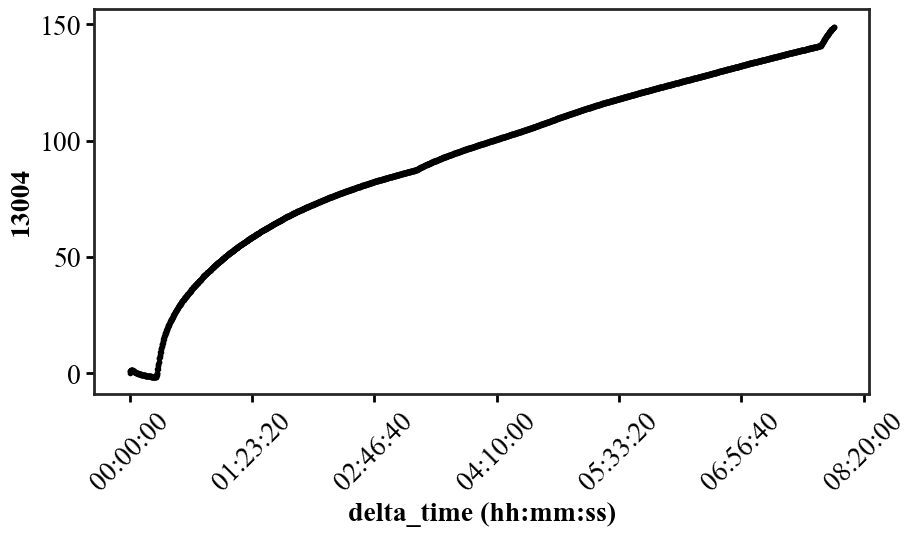

In [11]:
from matplotlib.ticker import FuncFormatter

# 过滤出 Date-Time 在 2022-03-15 09:00:00 起 8 小时内的数据，并以 delta_time 为 x 轴（显示为 hh:mm:ss），13004 为 y 轴绘图
start = pd.Timestamp("2022-03-15 09:00:00")
end = start + pd.Timedelta(hours=8)

mask = (sheet_df["Date-Time"] >= start) & (sheet_df["Date-Time"] <= end)
df_plot = sheet_df.loc[mask].copy()

if df_plot.empty:
    print("指定时间范围内无数据。")
else:
    # 使用 Date-Time - start 作为 x（Timedelta），并把 x 转为秒用于绘图，x 轴标签显示为 hh:mm:ss
    x_td = df_plot["Date-Time"] - start
    x_sec = x_td.dt.total_seconds()
    y = df_plot[13004]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x_sec, y, marker=".", linestyle="-")
    ax.set_xlabel("delta_time (hh:mm:ss)")
    ax.set_ylabel("13004")

    def _sec_to_hms(x, pos=None):
        h = int(x // 3600)
        m = int((x % 3600) // 60)
        s = int(x % 60)
        return f"{h:02d}:{m:02d}:{s:02d}"
    ax.xaxis.set_major_formatter(FuncFormatter(_sec_to_hms))

    plt.xticks(rotation=45)
    # plt.tight_layout()
    plt.show()

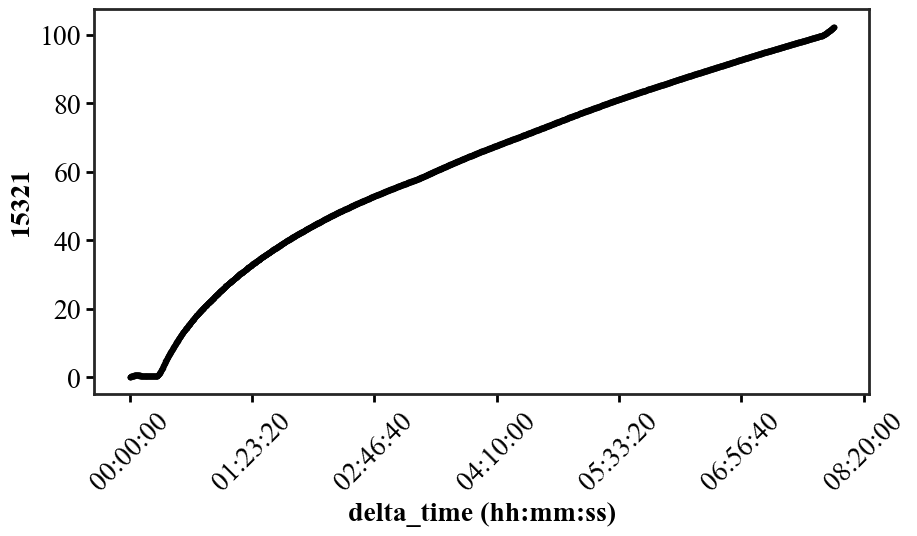

In [12]:
# 以 delta_time 为 x（显示为 hh:mm:ss），15321 为 y 绘图（时间范围已在 df_plot 中筛选）
if df_plot.empty:
    print("指定时间范围内无数据。")
else:
    # 优先复用已计算的 x_sec；若不存在则由 delta_time 解析得到秒数
    x = x_sec if "x_sec" in globals() else pd.to_timedelta(df_plot["delta_time"].astype(str)).dt.total_seconds()
    y_15321 = df_plot[15321]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x, y_15321, marker=".", linestyle="-")
    ax.set_xlabel("delta_time (hh:mm:ss)")
    ax.set_ylabel("15321")
    # ax.set_title("delta_time ~ 15321 (2022-03-15 09:00:00 起 8 小时)")

    # 复用已有的格式化函数；若不存在则定义一个
    try:
        fmt = FuncFormatter(_sec_to_hms)
    except NameError:
        def _sec_to_hms(val, pos=None):
            h = int(val // 3600)
            m = int((val % 3600) // 60)
            s = int(val % 60)
            return f"{h:02d}:{m:02d}:{s:02d}"
        fmt = FuncFormatter(_sec_to_hms)

    ax.xaxis.set_major_formatter(fmt)
    plt.xticks(rotation=45)
    # plt.tight_layout()
    plt.show()